# HSIC and Tangent Kernel Alignment

In [54]:
import sys, os
import warnings
import tqdm
import random
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

# Insert path to model directory,.
cwd = os.getcwd()
path = f"{cwd}/../../src"
sys.path.insert(0, path)

# Insert path to package,.
pysim_path = f"/home/emmanuel/code/pysim/"
sys.path.insert(0, pysim_path)

# toy datasets
from data.toy import generate_dependence_data
from data.distribution import DataParams
from dataclasses import dataclass

# Kernel Dependency measure
from models.dependence import HSICModel
from pysim.kernel.utils import get_init_gammas, get_gamma_grid, estimate_sigma

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-talk'])
%matplotlib inline

warnings.filterwarnings('ignore') # get rid of annoying warnings

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data I - 1D Dataset


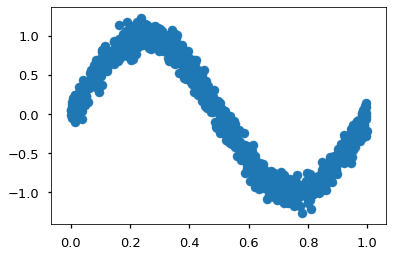

In [18]:
# data params
dataset = 'sine'
num_points = 1000
seed = 123
noise = 0.1

# get dataset
X, Y = generate_dependence_data(
    dataset=dataset,
    num_points=num_points,
    seed=seed,
    noise_x=noise,
    noise_y=noise
)

# plot
fig, ax = plt.subplots()

ax.scatter(X, Y)
plt.show()

## HSIC

In [52]:
def get_hsic(X, Y, scorer: str, sigma_X, sigma_Y):
    
    # init hsic model class
    hsic_model = HSICModel()

    # hsic model params
    hsic_model.kernel_X = RBF(sigma_X)
    hsic_model.kernel_Y = RBF(sigma_Y)

    # get hsic score
    hsic_val = hsic_model.get_score(inputs.X, inputs.Y, scorer)
    
    return hsic_val

### Original HSIC 

In [55]:
# hsic value and kernel alignment score
hsic_val = get_hsic(X, Y, 'hsic', sigma_X, sigma_Y)

print(f"HSIC: {hsic_val:.5f}")

HSIC: 0.00092


### Kernel Tangent Alignment

In [22]:


# hsic value and kernel alignment score
tka_val = clf_hsic.score(X, normalize=True)

print(f"TKA: {tka_val:.5f}")

TKA: 0.58843


#### Centered Kernel Tangent Alignment

In [5]:
# hsic params
kernel = 'rbf'
scorer = 'ctka'
subsample = None
bias = True

# initialize HSIC calculator
clf_hsic = HSIC(
    kernel=kernel, 
    scorer=scorer, 
    subsample=subsample,
    bias=bias
)


# calculate HSIC return scorer
clf_hsic.fit(X, Y);

# hsic value and kernel alignment score
tka_val = clf_hsic.hsic_value

print(f"TKA: {tka_val:.5f}")

TKA: 0.89475


## Length Scale

In [9]:
from sklearn.gaussian_process.kernels import RBF

In [41]:
def get_sigma(X, Y, method: str='silverman', per_dimension: bool=False):
    # sigma parameters
    subsample = None
    percent = 0.20
    random_state = 123

    sigma_X = estimate_sigma(
        X, 
        subsample=subsample,
        method=method,
        percent=percent,
        random_state=random_state,
        per_dimension=per_dimension
    )

    sigma_Y = estimate_sigma(
        Y, 
        subsample=subsample,
        method=method,
        percent=percent,
        random_state=random_state,
        per_dimension=per_dimension
    )
    return sigma_X, sigma_Y

In [35]:
# sigma parameters
per_dimension = False
method = 'silverman'
sigma_X, sigma_Y = get_sigma(method, per_dimension)

print(f"Estimated Sigma X: {sigma_X}")
print(f"Estimated Sigma Y: {sigma_Y}")

Estimated Sigma X: 0.06444718787975247
Estimated Sigma Y: 0.16119977831389598


The code below showcases an easy way to find the best kernel parameters by maximizing the HSIC value. This can be done with cross validation and the automatic training helper function found below.

## Data II - 2D Example

In [73]:
# initialize Data Params class
dataset = 'tstudent'
samples = 1_000
dimensions = 2
std = 5
nu = 8
trial = 1
standardize = False

# initialize params
example_params = DataParams(
    dataset=dataset,
    samples=samples,
    dimensions=dimensions,
    std=std,
    nu=nu,
    trial=trial,
    standardize=standardize
)

# generate some parameters
inputs = example_params.generate_data()

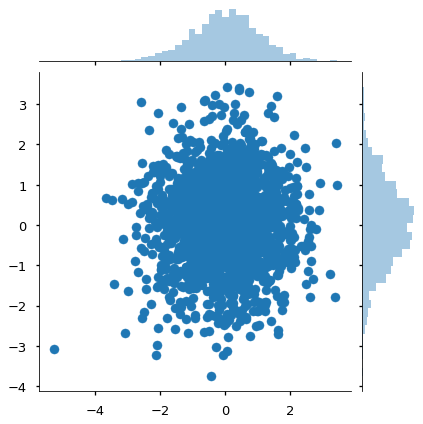

In [74]:
sns.jointplot(x=inputs.X, y=inputs.Y)

### Sigma Estimation

#### Case I - Same Length Scale

In [75]:
# sigma parameters
per_dimension = False
method = 'silverman'
sigma_X, sigma_Y = get_sigma(inputs.X, inputs.Y, method, per_dimension)

sigma_mu = np.mean([sigma_X,sigma_Y])
print(f"Estimated Sigma X: {sigma_X}")
print(f"Estimated Sigma Y: {sigma_Y}")
print(f"Estimated Sigma Y: {sigma_mu}")

Estimated Sigma X: 0.1949988419823719
Estimated Sigma Y: 0.19638960920405135
Estimated Sigma Y: 0.19569422559321165


In [76]:
# hsic value and kernel alignment score
scorers = ['hsic', 'ka', 'cka']
hsic_vals = [get_hsic(X, Y, iscorer, sigma_mu, sigma_mu) for iscorer in scorers]

print(f"HSIC: {hsic_vals[0]:.5f}")
print(f"CKA: {hsic_vals[1]:.5f}")
print(f"KA: {hsic_vals[2]:.5f}")

HSIC: 0.00096
CKA: 0.13180
KA: 0.10091


#### Case II - Different Length Scale

In [77]:
# sigma parameters
per_dimension = False
method = 'silverman'
sigma_X, sigma_Y = get_sigma(inputs.X, inputs.Y, method, per_dimension)

print(f"Estimated Sigma X: {sigma_X}")
print(f"Estimated Sigma Y: {sigma_Y}")

Estimated Sigma X: 0.1949988419823719
Estimated Sigma Y: 0.19638960920405135


In [78]:
# hsic value and kernel alignment score
scorers = ['hsic', 'ka', 'cka']
hsic_vals = [get_hsic(X, Y, iscorer, sigma_X, sigma_Y) for iscorer in scorers]

print(f"HSIC: {hsic_vals[0]:.5f}")
print(f"CKA: {hsic_vals[1]:.5f}")
print(f"KA: {hsic_vals[2]:.5f}")

HSIC: 0.00096
CKA: 0.13180
KA: 0.10091


#### Case III - Different Length Scale Per Dimension

In [79]:
# sigma parameters
per_dimension = True
method = 'scott'
sigma_X, sigma_Y = get_sigma(inputs.X, inputs.Y, method, per_dimension)

print(f"Estimated Sigma X: {sigma_X}")
print(f"Estimated Sigma Y: {sigma_Y}")

Estimated Sigma X: [0.26356727 0.26356727]
Estimated Sigma Y: [0.26544708 0.26544708]


In [80]:
# hsic value and kernel alignment score
scorers = ['hsic', 'ka', 'cka']
hsic_vals = [get_hsic(X, Y, iscorer, sigma_X, sigma_Y) for iscorer in scorers]

print(f"HSIC: {hsic_vals[0]:.5f}")
print(f"CKA: {hsic_vals[1]:.5f}")
print(f"KA: {hsic_vals[2]:.5f}")

HSIC: 0.00094
CKA: 0.11962
KA: 0.06002


## Standardize or Not Standardize the Data